# California housing regression

Adapted from https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_california_housing.html

See also
* [Scikit pipelines](https://mahmoudyusof.github.io/general/scikit-learn-pipelines/)
* [Ames housing price data](https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_ames_housing.html)

## Setup libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np

In [3]:
import sklearn
from sklearn.datasets import fetch_california_housing

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [5]:
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [6]:
import lightgbm as lgb

In [7]:
from lightgbm import LGBMRegressor

In [8]:
import matplotlib.pyplot as plt

In [9]:
pal = sns.color_palette()

## Get data

In [10]:
california_housing = fetch_california_housing(as_frame=True)

In [11]:
print(california_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

## Data summary

In [12]:
housing_raw = california_housing.frame

In [13]:
housing_raw.shape

(20640, 9)

List missing values

In [14]:
housing_raw.isna().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

## Outliers for some features

In [15]:
selected_features = ["AveRooms", "AveBedrms", "AveOccup", "Population"]

In [16]:
selected_features_df = housing_raw[selected_features]

In [17]:
selected_features_df.describe()

,AveRooms,AveBedrms,AveOccup,Population
count,20640.000000,20640.000000,20640.000000,20640.000000
mean,5.429000,1.096675,3.070655,1425.476744
std,2.474173,0.473911,10.386050,1132.462122
min,0.846154,0.333333,0.692308,3.000000
25%,4.440716,1.006079,2.429741,787.000000
50%,5.229129,1.048780,2.818116,1166.000000
75%,6.052381,1.099526,3.282261,1725.000000
max,141.909091,34.066667,1243.333333,35682.000000


In [18]:
selected_features_df.quantile(q=[0.5, 0.9, 0.99, 0.999, 0.9999])

,AveRooms,AveBedrms,AveOccup,Population
0.5000,5.229129,1.048780,2.818116,1166.0000
0.9000,6.961188,1.172727,3.885273,2566.0000
0.9900,10.357033,2.127541,5.394812,5805.8300
0.9990,34.199698,6.617232,13.630443,10372.6810
0.9999,62.383261,15.235731,485.062263,16293.3063


## Housing prices by latitude and longitude

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

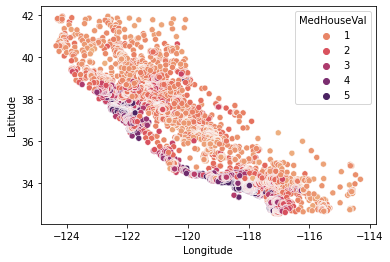

In [19]:
sns.scatterplot(
    data=housing_raw,
    x="Longitude",
    y="Latitude",
    hue="MedHouseVal",
    palette="flare",
)

Randomly sample a 500 point subset

In [20]:
rng = np.random.RandomState(0)
indices = rng.choice(np.arange(housing_raw.shape[0]), size=500, replace=False)

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

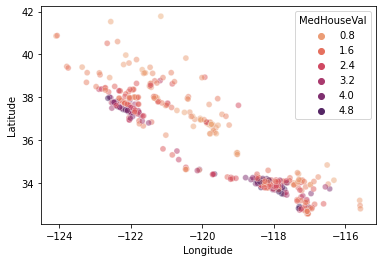

In [21]:
sns.scatterplot(
    data=housing_raw.iloc[indices],
    x="Longitude",
    y="Latitude",
    hue="MedHouseVal",
    palette="flare",
    alpha=0.5,
)

## Train the model

In [22]:
housing_df, housing_unseen = train_test_split(
    housing_raw, test_size=0.2, random_state=42, shuffle=True
)

In [23]:
y_val = housing_df.MedHouseVal
X_val = housing_df.drop(columns=['MedHouseVal'])

In [24]:
model = LGBMRegressor(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.1,
    n_estimators=100,
)

In [25]:
scoring = ['neg_mean_squared_error', 'r2']
scores = cross_validate(
    model, X_val, y_val, scoring=scoring, cv=10, return_train_score=False
)

In [26]:
scores.keys()

dict_keys(['fit_time', 'score_time', 'test_neg_mean_squared_error', 'test_r2'])

In [27]:
score = scores['test_r2']

In [28]:
print(
    "R2 {:.3f} +/- {:.3f}, count {}".format(
        np.mean(score), np.std(score), np.size(score)
    )
)

R2 0.836 +/- 0.009, count 10


## Grid search

In [29]:
gbm = LGBMRegressor()

In [30]:
param_grid = {
    "num_leaves": [31],
    "n_estimators": [100, 200, 400],
    "learning_rate": [0.05, 0.1, 0.2],
}

In [31]:
param_grid = {
    "num_leaves": [31],
    "n_estimators": [400],
    "learning_rate": [0.1],
}

In [32]:
grid = GridSearchCV(estimator=gbm, scoring="r2", cv=10, param_grid=param_grid)

In [33]:
grid.fit(X_val, y_val)

GridSearchCV(cv=10, estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.1], 'n_estimators': [400],
                         'num_leaves': [31]},
             scoring='r2')

In [34]:
grid.cv_results_["mean_test_score"]

array([0.84879679])

In [35]:
grid.best_params_

{'learning_rate': 0.1, 'n_estimators': 400, 'num_leaves': 31}

## Use best parameters

In [36]:
gbm_best = LGBMRegressor(**grid.best_params_)

In [37]:
gbm_best.fit(X_val, y_val)

LGBMRegressor(n_estimators=400)

In [38]:
y_test = housing_unseen.MedHouseVal
X_test = housing_unseen.drop(columns='MedHouseVal')

In [39]:
y_pred = gbm_best.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("R2 {:.3f}".format(r2))

R2 0.854
